# Open Context Zooarchaeology Measurements

This code gets meaurement data from Open Context to hopefully do some interesting things.

In the example given here, we're retrieving zooarchaeological measurements of fused metatarsal 3/4 bones classified as "Artiodactyla" (including more specific taxonomic catagories). The specific query used to select these bone data is:

https://opencontext.org/subjects-search/?prop=obo-foodon-00001303---gbif-1---gbif-44---gbif-359---gbif-731&prop=oc-zoo-anatomical-meas---oc-zoo-von-den-driesch-bone-meas&prop=oc-zoo-has-anat-id---obo-uberon-0013588#4/46.07/16.17/8/any/Google-Satellite

The OpenContextAPI() class has methods to get records from the query above by making multiple API requests. The OpenContextPlot() class has methods to generate scatter plots from the records retrieved via the OpenContextAPI() class.

In [1]:
# This imports the OpenContextAPI from the api.py file in the
# opencontext directory.
%run '../opencontext/api.py'

In [2]:
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_scatter_plot_from_oc_df(df, group_col, x_col, y_col):
    """Make a scatter plot from an Open Context dataframe"""
    if not set([group_col, x_col, y_col]).issubset(set(df.columns.tolist())):
        raise('Check for missing columns')
    
    # Now we're going to make a plot.
    markers = [
        'o',
        'x',
        'v',
        'D',
        'p',
        '^',
        's',
        '*',
    ]
    
    group_vals = df[group_col].unique().tolist()
    colors = cm.rainbow(np.linspace(0, 1, len(group_vals)))
    ax = None
    i = 0
    for group_val in group_vals:
        act_index = (
            (df[group_col] == group_val)
            & ~df[x_col].isnull()
            & ~df[y_col].isnull()
        )
        if df[act_index].empty:
            # No data for this taxon
            continue
        label = '{} [n={}]'.format(group_val, len(df[act_index].index))
        if i < len(markers):
            marker = markers[i]
        else:
            marker = random.choice(markers)
        if not ax:
            ax = df[act_index].plot.scatter(
                x=x_col, 
                y=y_col, 
                marker=marker, 
                label=label, 
                color=colors[i].reshape(1,-1),
            )
            ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
            plot = df[act_index].plot.scatter(
                x=x_col, 
                y=y_col, 
                marker=marker, 
                label=label, 
                ax=ax, 
                color=colors[i].reshape(1,-1),
            )
            plot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        i += 1


In [3]:
import numpy as np
import pandas as pd

oc_api = OpenContextAPI()

# Clear old cached records.
oc_api.clear_api_cache()

# This is a search url for bovid tibias.
url = 'https://opencontext.org/subjects-search/?prop=obo-foodon-00001303---gbif-1---gbif-44---gbif-359---gbif-731&prop=oc-zoo-anatomical-meas---oc-zoo-von-den-driesch-bone-meas&prop=oc-zoo-has-anat-id---obo-uberon-0013588#4/46.07/16.17/8/any/Google-Satellite'

# Fetch the 'standard' (linked data identified) attributes in use with
# data at the url.
stnd_attribs_tuples = oc_api.get_standard_attributes(
    url,
    # The optional argument below gets popular standard
    # zooarchaeological (bone) measurements.
    add_von_den_driesch_bone_measures=True
)

        

In [4]:
# Make a list of only the slugs from the list of slug, label tuples.
stnd_attribs = [slug for slug, _ in stnd_attribs_tuples]

# Make a dataframe by fetching result records from Open Context.
# This will be slow until we finish improvements to Open Context's API.
# However, the results get cached by saving as files locally. That
# makes iterating on this notebook much less painful.
df = oc_api.url_to_dataframe(url, stnd_attribs)

## Observing some of the outliers
The plot below shows we probably have some measurement and/or recording errors.

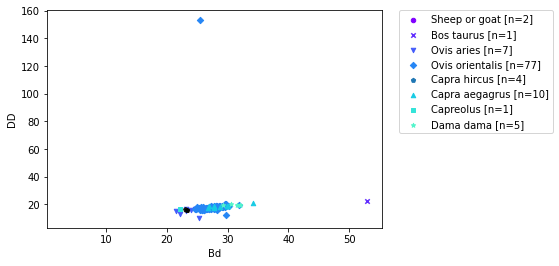

In [5]:
# Make a plot of Bd verses DD for different taxa
make_scatter_plot_from_oc_df(
    df, 
    group_col='Has taxonomic identifier', 
    x_col='Bd', 
    y_col='DD'
)



We can make a more reasonable plot by throughing out the outlier (likely recording error).

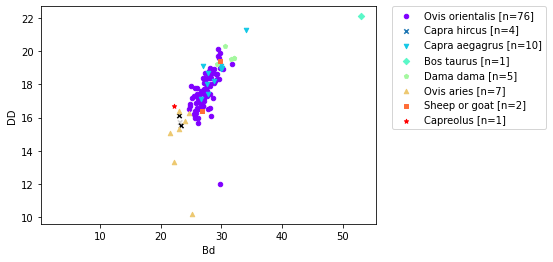

In [6]:
# Make a plot of Bd verses DD for different taxa, limiting DD to reasonable values.
make_scatter_plot_from_oc_df(
    df[(df['DD'] < 80)], 
    group_col='Has taxonomic identifier', 
    x_col='Bd', 
    y_col='DD'
)

Now to try another scatter plot, looking at measurements from the proximal end of the bone rather than the distal.

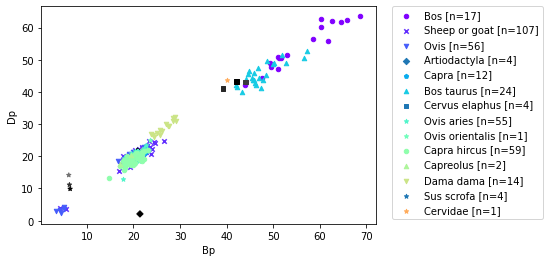

In [7]:
# Make a plot of Bp verses Dp for different taxa
make_scatter_plot_from_oc_df(
    df, 
    group_col='Has taxonomic identifier', 
    x_col='Bp', 
    y_col='Dp'
)